# EX1) Comparision of Calibration of Classifiers

- 분류 확률 추정치 반환: predict_proba
- 여러 모델들의 결과 비교해보기

In [3]:
# Dataset

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

X, y = make_classification(
    n_samples=100_000, n_features=20, n_informative=2, n_redundant=2, random_state=42
)

train_samples = 100
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=100_000 - train_samples,
)

In [5]:
X_train.shape, X_test.shape

((100, 20), (99900, 20))

In [21]:
# Calibration curves : 4개 모델을 작은 데이터로 훈련해서 해당 커브 (reliability diagrams)를 보고자 함. 

import numpy as np

from sklearn.svm import LinearSVC

class NaivelyCalibratedLinearSVC(LinearSVC):
    # decision_function 결과가 곧 predict_proba

    def fit(self, X, y):
        super().fit(X, y)
        df = self.decision_function(X)
        self.df_min_ = df.min()
        self.df_max_ = df.max()

    def predict_proba(self, X):
        # Min-max 스케일된 0~1 값 (decision function)
        df = self.decision_function(X)
        calibrated_df = (df - self.df_min_) / (self.df_max_ - self.df_min_)
        proba_pos_class = np.clip(calibrated_df, 0, 1)
        proba_neg_class = 1 - proba_pos_class
        proba = np.c_[proba_neg_class, proba_pos_class]
        return proba

In [22]:
LinearSVC(C=1.0, dual='auto')

LinearSVC(dual='auto')

In [23]:
from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

## Create classifiers
lr = LogisticRegression()
gnb = GaussianNB()
svc = NaivelyCalibratedLinearSVC(C=1.0, dual=True)
rfc = RandomForestClassifier()

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (svc, "SVC"),
    (rfc, "Random forest")
]

/opt/homebrew/anaconda3/envs/lecture/lib/python3.9/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/opt/homebrew/anaconda3/envs/lecture/lib/python3.9/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/opt/homebrew/anaconda3/envs/lecture/lib/python3.9/site-packages/sklearn/calibration.py:1176: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "s-" (-> marker='s'). The keyword argument will take precedence.
  self.line_ = ax.plot(self.prob_pred, self.prob_true, "s-", **line_kwargs)[0]
/

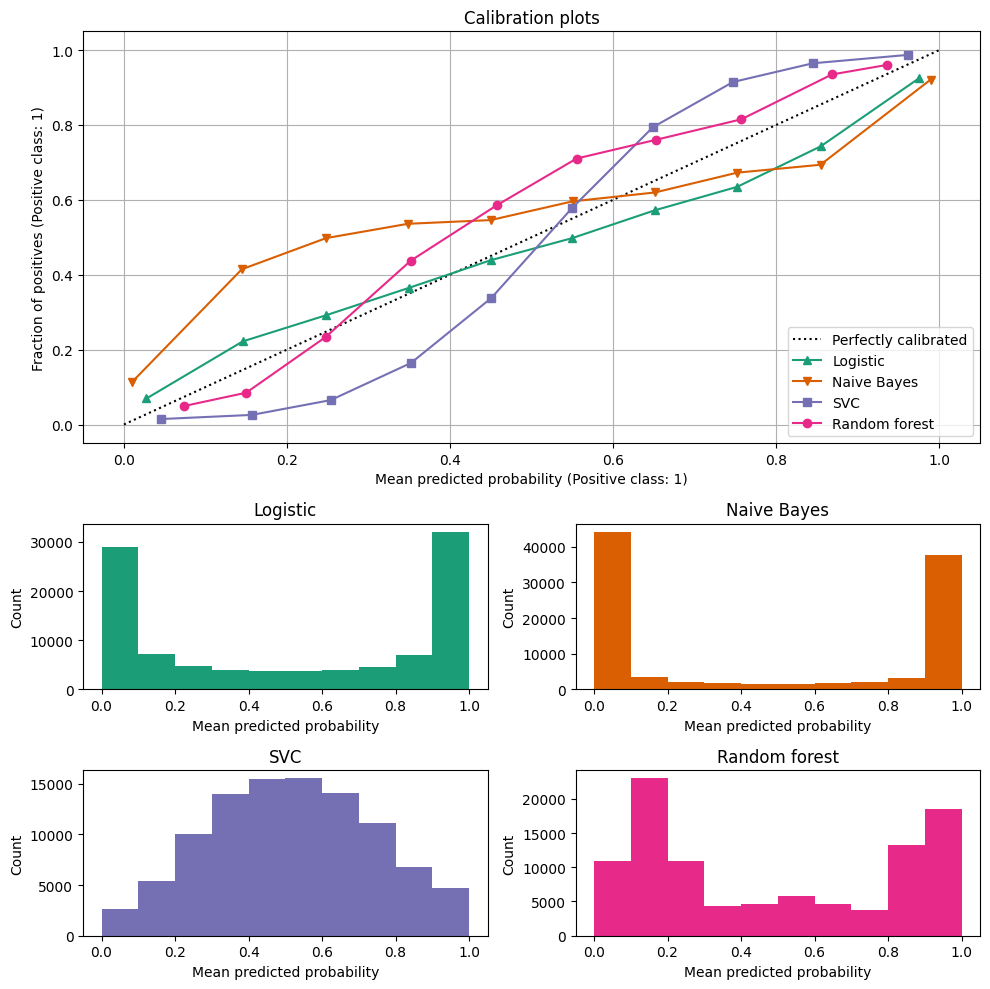

In [24]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o"]

grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

plt.tight_layout()
plt.show()


* 해석
    - 가장 위 그래프를 보았을 때, lr이 가장 Loss가 적음
    - nb는 0과 1의 편향성이 두드러짐. 나이브 베이즈 수식의 피쳐들이 독립적일 때 정확한 확률 추정 제공. (하지만 그래프는 양의 상관관계를 갖는 경향이 있음)
    - rf는 0.2와 0.9에 정점을 찍음. 배깅과 랜덤포레스트 방법론을 사용했을 때, 분산으로 인해 0과 1에 가까운 값이 나오는 경향이 있음.
    - svc는 확률 출력하지 않음.(min-max 적용) 